In [41]:
import numpy as np
import pandas as pd
class BinomialAssetPricingModel:
    def __init__(self, S0, u, d, r, n, K):
        self.S0 = S0
        self.u = u
        self.d = d
        self.r = r
        self.n = n 
        self.K = K
        
    def asset_price(self, i):
        return round(self.S0 * (self.u ** i) * (self.d ** (self.n - i)),3)

    def full_asset_price(self):
        v = [[0.000 for i in range(self.n + 1)] for j in range(self.n + 1)]
        for i in range(self.n+1):
            v[self.n][i] = self.asset_price(i)

        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                v[j][i] = round((self.d*v[j + 1][i + 1] + self.u* v[j + 1][i])/2,3)

        return v

    def buy_option_price(self):
        p = (1 + self.r - self.d) / (self.u - self.d)
        v = [[0.000 for i in range(self.n + 1)] for j in range(self.n + 1)]

        for i in range(self.n + 1):
            v[self.n][i] = max(0.000, self.asset_price(i) - self.K)

        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                v[j][i] = round((1 / (1 + self.r)) * (p * v[j + 1][i + 1] + (1 - p) * v[j + 1][i]),3)

        return v

    def sell_option_price(self):
        p = (1 + self.r - self.d) / (self.u - self.d)
        v = [[0.000 for i in range(self.n + 1)] for j in range(self.n + 1)]

        for i in range(self.n + 1):
            v[self.n][i] = max(0.000, self.K - self.asset_price(i))

        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                v[j][i] = round((1 / (1 + self.r)) * (p * v[j + 1][i + 1] + (1 - p) * v[j + 1][i]),3)

        return v

    def shares_of_stock(self):
        v = [[0.000 for i in range(self.n + 1)] for j in range(self.n + 1)]
        v1 = self.buy_option_price()
        v2 = self.full_asset_price()
        for j in range(self.n, -1, -1):
            for i in range(j):
                v[j-1][i] = round((v1[j][i]-v1[j][i+1])/(v2[j][i]-v2[j][i+1]),3)
        return pd.DataFrame(v)
    
    def  money_in_bank(self):
        v = [[0.000 for i in range(self.n + 1)] for j in range(self.n + 1)]
        v1 = self.buy_option_price()
        v2 = self.full_asset_price()
        v3 = self.shares_of_stock()
        
        for j in range(len(v)):
            for i in range(len(v)):
                v[j][i] = round(v1[j][i] - v2[j][i]*v3[j][i],3)
        return pd.DataFrame(v)
        

In [ ]:
# Create an instance of the class
S0=100
u=1.07
d=1/u
r=0.01
n=3
K=100
model = BinomialAssetPricingModel(S0, u, d, r, n, K)

# Call the asset_price method to calculate the price of the asset at time step n, i=n
asset_price = model.full_asset_price()
print(f'Asset price: \n{pd.DataFrame(asset_price)}\n')

# Call the option_price method to calculate the price of the option with strike price K=100 at time all
buy_option_price = model.buy_option_price()
print(f'Buy Option price (European Options): \n{pd.DataFrame(buy_option_price)}\n')

sell_option_price = model.sell_option_price()
print(f'Sell Option price (American Options): \n{pd.DataFrame(sell_option_price)}\n')

stock = model.shares_of_stock()
print(f"Share of stock: \n{stock}\n")

bank = model.money_in_bank()
print(f"Money invested in bank \n{bank}\n")

In [14]:
import numpy as np
import pandas as pd

class BinomialAssetPricingModel:
    """
    A class to calculate various quantities related to a binomial asset pricing model.
    """
    def __init__(self, S0: float, u: float, d: float, r: float, n: int, K: float):
        """
        Initialize the binomial asset pricing model.
        
        Parameters:
            S0 (float): Initial asset price
            u (float): Up factor
            d (float): Down factor
            r (float): Risk-free rate
            n (int): Number of time steps
            K (float): Strike price
        """
        self.S0 = S0
        self.u = u
        self.d = d
        self.r = r
        self.n = n 
        self.K = K
        self.p = (1 + self.r - self.d) / (self.u - self.d)
        
    def asset_price(self, i: int) -> float:
        """
        Calculate the asset price at a given time step.
        
        Parameters:
            i (int): Time step
        
        Returns:
            float: Asset price
        """
        return self.S0 * (self.u ** i) * (self.d ** (self.n - i))

    def full_asset_price(self) -> pd.DataFrame:
        """
        Calculate the full asset price for each node in the binomial tree.
        
        Returns:
            pd.DataFrame: Asset prices
        """
        v = [[0.0 for _ in range(self.n + 1)] for _ in range(self.n + 1)]
        for i in range(self.n+1):
            v[self.n][i] = self.asset_price(i)

        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                v[j][i] = (self.d*v[j + 1][i + 1] + self.u* v[j + 1][i])/2

        return pd.DataFrame(v)

    def buy_option_price(self) -> pd.DataFrame:
        """
        Calculate the option price for buying the asset.
        
        Returns:
            pd.DataFrame: Option prices
        """
        v = [[0.0 for _ in range(self.n + 1)] for _ in range(self.n + 1)]

        for i in range(self.n + 1):
            v[self.n][i] = max(0.0, self.asset_price(i) - self.K)

        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                v[j][i] = (1 / (1 + self.r)) * (self.p * v[j + 1][i + 1] + (1 - self.p) * v[j + 1][i])

        return pd.DataFrame(v)

    def sell_option_price(self) -> pd.DataFrame:
        """
        Calculate the option price for selling the asset.
        
        Returns:
            pd.DataFrame: Option prices
        """
        v = [[0.0 for _ in range(self.n + 1)] for _ in range(self.n + 1)]

        for i in range(self.n + 1):
            v[self.n][i] = max(0.0, self.K - self.asset_price(i))

        for j in range(self.n - 1, -1, -1):
            for i in range(j + 1):
                v[j][i] = (1 / (1 + self.r)) * (self.p * v[j + 1][i + 1] + (1 - self.p) * v[j + 1][i])

        return pd.DataFrame(v)

    def shares_of_stock(self) -> pd.DataFrame:
        """
        Calculate the number of shares of stock held at each node in the binomial tree.
        
        Returns:
            pd.DataFrame: Shares of stock
        """
        v = [[0.0 for _ in range(self.n + 1)] for _ in range(self.n + 1)]
        buy_option = self.buy_option_price()
        full_asset = self.full_asset_price()
        for j in range(self.n, -1, -1):
            for i in range(j):
                v[j-1][i] = (buy_option.iloc[j,i]-buy_option.iloc[j,i+1])/(full_asset.iloc[j,i]-full_asset.iloc[j,i+1])
        return pd.DataFrame(v)

    def money_in_bank(self) -> pd.DataFrame:
        """
        Calculate the money in the bank at each node in the binomial tree.
        
        Returns:
            pd.DataFrame: Money in the bank
        """
        v = [[0.0 for _ in range(self.n + 1)] for _ in range(self.n + 1)]
        buy_option = self.buy_option_price()
        full_asset = self.full_asset_price()
        shares = self.shares_of_stock()
        
        for j in range(len(v)):
            for i in range(len(v)):
                v[j][i] = buy_option.iloc[j,i] - full_asset.iloc[j,i]*shares.iloc[j,i]
        return pd.DataFrame(v)



In [4]:
# Create an instance of the class
S0=100
u=1.07
d=1/u
r=0.01
n=3
K=100
model = BinomialAssetPricingModel(S0, u, d, r, n, K)

# Call the asset_price method to calculate the price of the asset at time step n, i=n
asset_price = model.full_asset_price()
print(f'Asset price: \n{pd.DataFrame(asset_price)}\n')

# Call the option_price method to calculate the price of the option with strike price K=100 at time all
buy_option_price = model.buy_option_price()
print(f'Buy Option price (European Options): \n{pd.DataFrame(buy_option_price)}\n')

sell_option_price = model.sell_option_price()
print(f'Sell Option price (American Options): \n{pd.DataFrame(sell_option_price)}\n')

stock = model.shares_of_stock()
print(f"Share of stock: \n{stock}\n")

bank = model.money_in_bank()
print(f"Money invested in bank \n{bank}\n")

Asset price: 
            0           1       2         3
0  100.000000    0.000000    0.00    0.0000
1   93.457944  107.000000    0.00    0.0000
2   87.343873  100.000000  114.49    0.0000
3   81.629788   93.457944  107.00  122.5043

Buy Option price (European Options): 
          0          1          2        3
0  6.574383   0.000000   0.000000   0.0000
1  2.128460  10.229334   0.000000   0.0000
2  0.000000   3.859951  15.480099   0.0000
3  0.000000   0.000000   7.000000  22.5043

Sell Option price (American Options): 
           0         1    2    3
0   3.633398  0.000000  0.0  0.0
1   6.700121  1.258939  0.0  0.0
2  11.666028  2.869852  0.0  0.0
3  18.370212  6.542056  0.0  0.0

Share of stock: 
          0         1    2    3
0  0.598201  0.000000  0.0  0.0
1  0.304987  0.801943  0.0  0.0
2 -0.000000  0.516908  1.0  0.0
3  0.000000  0.000000  0.0  0.0

Money invested in bank 
           0         1          2        3
0 -53.245734   0.00000   0.000000   0.0000
1 -26.374975 -75.5

In [15]:
import numpy as np
import matplotlib.pyplot as plt 
def monte_carlo_simulation(S0: float, mu: float, sigma: float, T: float, N: int, I: int):
    """
    Perform a Monte Carlo simulation for a given stock price process.
    
    Parameters:
        S0 (float): Initial stock price
        mu (float): Drift rate
        sigma (float): Volatility
        T (float): Time horizon (in years)
        N (int): Number of time steps
        I (int): Number of simulations
        
    Returns:
        np.ndarray: Simulated stock prices
    """
    dt = T/N
    S = np.zeros((N+1, I))
    S[0] = S0
    for t in range(1, N+1):
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * np.random.normal(size=I))
    return S



          0         1     2
0  5.612245  0.000000   0.0
1  0.000000  7.857143   0.0
2  0.000000  0.000000  11.0


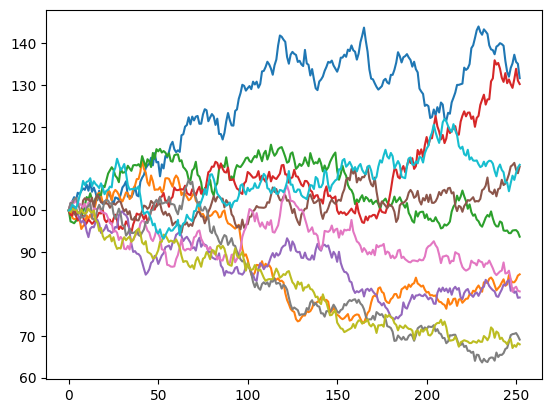

In [19]:
# Create an instance of the class
S0 = 100.0 # Initial asset price
u = 1.1 # Up factor
d = 0.9 # Down factor
r = 0.05 # Risk-free rate
n = 2 # Number of time steps
K = 110.0 # Strike price
bapm = BinomialAssetPricingModel(S0, u, d, r, n, K)

# Call the buy_option_price method
buy_option_prices = bapm.buy_option_price()

mu = 0.05 # Drift rate
sigma = 0.2 # Volatility
T = 1.0 # Time horizon (in years)
N = 252 # Number of time steps (assuming 252 trading days per year)
I = 10 # Number of simulations

simulated_stock_prices = monte_carlo_simulation(S0, mu, sigma, T, N, I)
print(buy_option_prices)
plt.plot(simulated_stock_prices)

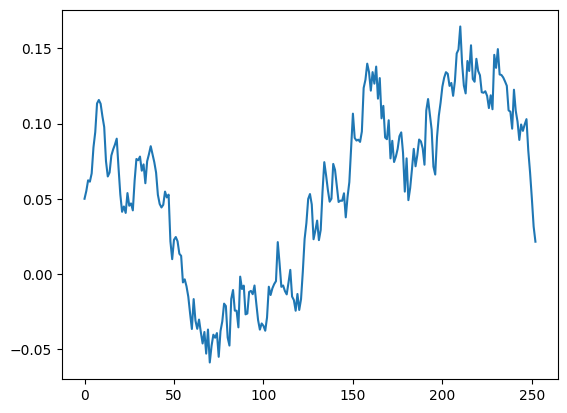

In [23]:
import numpy as np

def brownian_motion(T: float, N: int, mu: float, sigma: float, seed: int = None):
    """
    Generate a Brownian motion process using the Euler-Maruyama method.
    
    Parameters:
        T (float): Time horizon (in years)
        N (int): Number of time steps
        mu (float): Drift rate
        sigma (float): Volatility
        seed (int): Seed for the random number generator (default: None)
    
    Returns:
        np.ndarray: Brownian motion process
    """
    dt = T/N
    np.random.seed(seed)
    W = np.cumsum(np.random.normal(loc=0, scale=np.sqrt(dt), size=(1, N))[0])
    W = np.insert(W, 0, 0)
    return mu*T + sigma*W

# Example usage:
T = 1.0 # Time horizon (in years)
N = 252 # Number of time steps (assuming 252 trading days per year)
mu = 0.05 # Drift rate
sigma = 0.2 # Volatility

bm = brownian_motion(T, N, mu, sigma)
def update(num):
    ax.clear()
    ax.plot(bm[:num])

ani = FuncAnimation(fig, update, frames=range(1, len(bm)))
plt.show()

In [30]:
import numpy as np
def martingale_strategy(S: np.ndarray, stake: float, stop_loss: float):
    """
    Implement the Martingale strategy for a given stock price process.
    
    Parameters:
        S (np.ndarray): Stock price process
        stake (float): Initial stake
        stop_loss (float): Stop loss level
        
    Returns:
        np.ndarray: Account balance at each time step
    """
    n = S.shape[0]
    balance = np.zeros(n)
    balance[0] = stake
    position = 0
    for t in range(1, n):
        if position == 0:
            # If not holding a position, buy one unit of stock
            position += 1
            balance[t] = balance[t-1] - S[t]
        elif S[t] < S[t-1]:
            # If stock price decreased, double position
            position *= 2
            balance[t] = balance[t-1] - position * S[t]
        else:
            # If stock price increased, keep the same position
            balance[t] = balance[t-1] + position * (S[t] - S[t-1])
        if balance[t] < stop_loss:
            # If account balance falls below stop loss level, exit the position
            position = 0
            balance[t] = stop_loss
    return balance


# Example usage:
S0 = 100.0 # Initial asset price
mu = 0.05 # Drift rate
sigma = 0.2 # Volatility
T = 1.0 # Time horizon (in years)
N = 252 # Number of time steps (assuming 252 trading days per year)
I = 1000 # Number of simulations

simulated_stock_prices = monte_carlo_simulation(S0, mu, sigma, T, N, I)

# Implement the Martingale strategy
stake = 100.0 # Initial stake
stop_loss = 0.0 # Stop loss level

account_balance = np.zeros((I, N))


for i in range(I):
    account_balance[i] = martingale_strategy(simulated_stock_prices[i, :], stake, stop_loss).reshape(-1, 1)


ValueError: could not broadcast input array from shape (1000,1) into shape (252,)

In [ ]:
plt.plot(test_df["price"])
plt.plot(predictions)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import accuracy_score

In [50]:
stock = "GOOGL"
df = pd.DataFrame(yf.download(stock, '2010-01-01', '2022-12-31')["Close"])


[*********************100%***********************]  1 of 1 completed


In [49]:
def rolling(lag, data):
    A = []
    df = data.tolist()
    for i in range(lag, len(df)):
        A.append(df[i-lag:i]) 
    return pd.DataFrame(A)

def GradientBoost(x,y):
    model = GradientBoostingRegressor()  
    model.fit(x,y)
    return model
    
def UoD(x):
    if x<0:
        return -1
    else: 
        return 1
    
def train_test_split(x,y,test_size):
    i = int(len(x)*test_size)
    j = int(len(y)*test_size)
    return x[:i], x[i:], y[:j], y[j:]

In [51]:
df["returns"] =df.pct_change()
df["UoD"]= df["returns"].map(UoD)

In [78]:
lag = 3
A = rolling(lag, df["Close"])
b = df["Close"][lag::]
deon, dete, keyon, keyte = train_test_split(A,b, test_size=0.9)

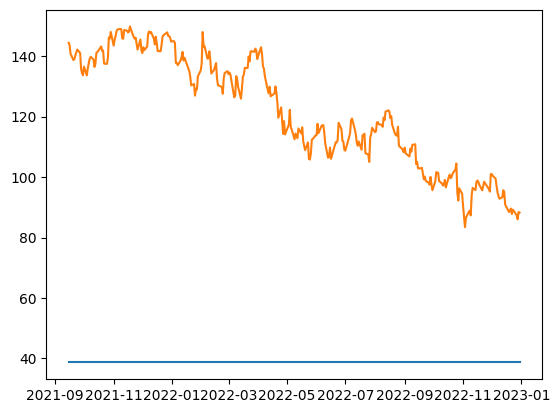

In [82]:

plt.plot(keyte.index,a.predict(dete))
plt.plot(keyte)

In [84]:
a.predict(deon)

array([15.21920896, 14.87097226, 15.07477801, ..., 38.63925183,
       38.63925183, 38.63925183])

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM

In [86]:
stock = "GOOGL"
df = pd.DataFrame(yf.download(stock, '2010-01-01', '2022-12-31')["Close"])

[*********************100%***********************]  1 of 1 completed


In [87]:
def rolling(lag, data):
    A = []
    df = data.values
    for i in range(lag, len(df)):
        A.append(df[i-lag:i]) 
    return A

def train_test_split(x,y,test_size):
    i = int(len(x)*test_size)
    j = int(len(y)*test_size)
    return x[:i], x[i:], y[:j], y[j:]
               
def RNN(x, y, lag):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(lag,1)))
    model.add(Dropout(0.5))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=50))
    model.add(Dropout(0.3))
    model.add(Dense(units=1))

    #RMSProp is working fine with LSTM but so do ADAM optimizer
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(np.array(x), np.array(y), epochs=100, batch_size=32)
    return model

In [92]:
lag = 5
A = rolling(lag, df["Close"])
b = df["Close"].values[lag::]

deon, dete, keyon, keyte = train_test_split(A,b, test_size=0.9)

In [93]:
a = RNN(deon,keyon,lag)

Epoch 1/100
92/92 [==============================] - 9s 14ms/step - loss: 1848.4338
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 1438.8090
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 1234.5352
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 1078.8157
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 975.9381
Epoch 6/100
92/92 [==============================] - 1s 14ms/step - loss: 899.2399
Epoch 7/100
92/92 [==============================] - 1s 14ms/step - loss: 848.1636
Epoch 8/100
92/92 [==============================] - 1s 14ms/step - loss: 690.7837
Epoch 9/100
92/92 [==============================] - 1s 14ms/step - loss: 602.8832
Epoch 10/100
92/92 [==============================] - 2s 16ms/step - loss: 527.8573
Epoch 11/100
92/92 [==============================] - 1s 14ms/step - loss: 474.7422
Epoch 12/100
92/92 [==============================] - 1s 15ms/step - loss: 425.53

11/11 [==============================] - 0s 5ms/step


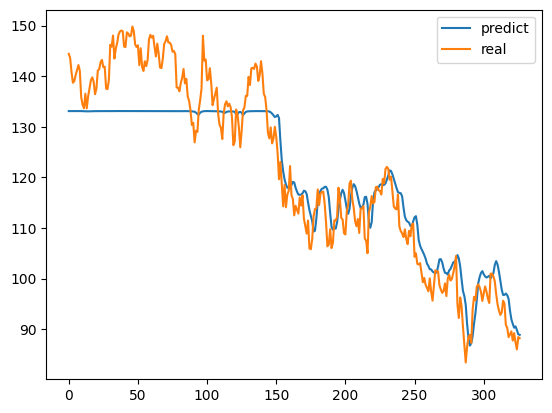

In [95]:
plt.plot(a.predict(np.array(dete)), label="predict")
plt.plot(np.array(keyte), label="real")
plt.legend()
plt.show()